## Explaining the Network Predictions for NR-AhR in the TOX21 Dataset

Neural networks can seem like a black box where it is not obvious how the network reached its conclusion. Here we go back to the GAT, GIN and MPNN networks that we have previously trained and study their decision making.

In order to do so, we use post-hoc explaining algorithms. These take trained networks as an input and try to identify the features which have the biggest impact on the decision making of the network. In the case of GNNs these algorithms produce a mask for node and edge features which mask everything but the most important features and edges.

Here we focus on GNNExplainer (https://arxiv.org/abs/1903.03894) and AttentionExplainer and compore it to a DummyExplainer which produces random masks. Any explanation algorithm should at least perform better than the DummyExplainer. GNNExplainer finds masks of a fixed size which maximize the mutual information with the full graph with respect to the model predictions. The AttentionExplainer uses the learned attention coefficients in a GAT to identify the most important edges. We use the pytorch geometric implementation of these explanation algorithms (https://pytorch-geometric.readthedocs.io/en/2.5.2/modules/explain.html).

In order to evaluate how good the explanations are, we need metrics. A good explanation needs to things: i) the identified key features and edges should reproduce the model prediction (fidelity) and ii) the amount of key features and edges should be as small as possible to condense the most important information and make it understandable for humans (sparsity). In our experiments we study the fidelity as a function of sparsity, i.e. how many key features or edges we allow. A more rigorous definition of the fidelity is
$$fid_+ = 1 - \frac{1}{N}\sum_{i=1}^N \mathcal{1}(\hat{y}_i^{G_{C/S}} = \hat{y}_i)\,,$$
$$fid_- = 1 - \frac{1}{N}\sum_{i=1}^N \mathcal{1}(\hat{y}_i^{G_{S}} = \hat{y}_i)\,,$$
where the sum goes over the $N$ samples in the dataset, $G_{S}$ is the subgraph generated by the learned masks for the key features and edges and $G_{C/S}$ is its complement, the full graph without the most important features and edges.

For a good explainer one wants $fid_-$ to be small, i.e. with the few key features identified by the explainer we want to be able to reproduce the model prediction on the full graph (Note it is $1-$ average number of correct predictions of subgraph). If one restricts the sparsity, i.e. the allowed number of key features or edges, in general $fid_-$ will decrease from close to $1$ to smaller values as the number of allowed features is increased. The faster the decrease, the better the explainer. For $fid_+$ we expect the opposite. For very sparse explainer settings we expect $fid_+$ to be close to $0$, since just removing very few features or edges probably does not have a big effect on the prediction. But as $fid_-$ decreases, $fid_+$ should increase since without the key features we do not expect to be able to reproduce the model predictions accurately. However, especially in binary classification, as we will see below, those values might not always start from $0$ or $1$ but somewhere in between.

In https://arxiv.org/pdf/2206.09677 the fidelity scores are related to the two concepts of **Sufficient Explanation** and **Necessary Explanation**

* **Sufficient Explanation**: an explanation is sufficient if it leads to the right predictions on its own, i.e. it has a $fid_-$ score close to $0$. Note that it can be possible to have several sufficient explanations for the same prediction
* **Necessary Explanation**: an explanation is necessary if the prediction changes when the explanation is removed from the graph, i.e. it has a $fid_+$ score close to one.

A good explainability algorithm yields both sufficient and necessary explanations.

---

### Contents
In the following we are going to
1. Apply GNNExplainer, AttentionExplainer and the DummyExplainer to all network architectures and compare their performance using fidelity measures
    1. [Explaining the GAT Classifier](#GAT_sec)
    2. [Explaining the GIN Classifier](#GIN_sec)
    3. [Explaining the MPNN Classifier](#MPNN_sec)
    4. [Compare the Results](#comp_sec)
2. [Discuss the explanations from GNNExplainer](#example) for an explicit example and compare the explanations from different architectures on the same graph

---

## 1. Benchmark Explainers for different model architectures

Let us first load the required modules and the dataset

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import os
from dataset import Tox21Dataset
from torch_geometric.explain import Explainer, AttentionExplainer, DummyExplainer, GNNExplainer
from torch_geometric.explain.metric import fidelity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd()
data_dir = os.path.join(root_dir,'data_1')
ds = Tox21Dataset(root=data_dir, task=['NR-AhR'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ds.to(device)

Processing...
[00:18:10] WARNING: not removing hydrogen atom without neighbors
[00:18:10] Explicit valence for atom # 8 Al, 6, is greater than permitted
[00:18:10] Explicit valence for atom # 3 Al, 6, is greater than permitted
[00:18:10] Explicit valence for atom # 4 Al, 6, is greater than permitted
[00:18:10] Explicit valence for atom # 4 Al, 6, is greater than permitted
[00:18:11] Explicit valence for atom # 9 Al, 6, is greater than permitted
[00:18:11] Explicit valence for atom # 5 Al, 6, is greater than permitted
[00:18:11] Explicit valence for atom # 16 Al, 6, is greater than permitted
[00:18:11] Explicit valence for atom # 20 Al, 6, is greater than permitted
Done!
/opt/homebrew/anaconda3/lib/python3.13/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([rdkit.Chem.rdchem.Mol])` to allowlist this global.
  warnings.w

Tox21Dataset(6542)

Now we define a function that takes an explanation algorithm and returns a list of $fid_+$ and $fid_-$ scores for a given dataset

In [2]:
topk_list = [1, 5, 10, 15, 20, 30, 40, 50]

def benchmark_explainer(model, exp, dataset, topkList,
                        node_mask=None, edge_mask=None):
  """Benchmarks a given explainer on a dataset using fidelity metrics.

  Args:
      model (torch.nn.Module): The trained graph neural network model.
      exp (torch_geometric.explain.Explainer): The explainer algorithm to benchmark.
      dataset (torch_geometric.data.Dataset): The dataset to use for benchmarking.
      topkList (list): A list of top-k values to use for thresholding the explanations.
      node_mask (str, optional): The type of node mask to use ('individual' or 'common').
                                 Defaults to None.
      edge_mask (str, optional): The type of edge mask to use ('individual' or 'common').
                                 Defaults to None.

  Returns:
      tuple: A tuple containing two lists:
          - fidp_final (list): A list of mean fidelity_plus scores for each top-k value.
          - fidm_final (list): A list of mean fidelity_minus scores for each top-k value.
  """
  fidp_final =[]
  fidm_final =[]

  for topk in topkList:
    print(f'Topk={topk}, Start Explainer')
    explainer = Explainer(
            model=model,
            algorithm=exp,
            explanation_type='model',
            node_mask_type=node_mask,
            edge_mask_type=edge_mask,
            model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
            threshold_config=dict(threshold_type='topk', value=topk)
        )

    fidp_list = []
    fidm_list = []
    for i in tqdm(range(len(dataset))):
        explanation = explainer(dataset[i].x, dataset[i].edge_index, edge_attr=dataset[i].edge_attr)
        fidp, fidm = fidelity(explainer, explanation)
        fidp_list.append(fidp)
        fidm_list.append(fidm)

    print(f'Result: fidelity_plus={np.mean(fidp_list):.4f}, fidelity_minus={np.mean(fidm_list):.4f}')
    fidp_final.append(np.mean(fidp_list))
    fidm_final.append(np.mean(fidm_list))
  return fidp_final, fidm_final

## 1.1 Explaining Prediction with the GAT Architecture
<a id='GAT_sec'></a>

We first have a look at the GAT Architecture and will try to explain it's predictions. We first load the model and then we will run the above explainer benchmark code

In [3]:
from models import simpleGAT

do = 0.4
num_layer = 4
num_hidden = 64

modelGAT = simpleGAT(in_channels=ds[0].x.size(1), dim_h=num_hidden, out_channels=ds[0].y.size(0), num_layers=num_layer, heads=4, dropout=do)
state_dict = torch.load(os.path.join(root_dir, "models/final/GAT_best.pth"))['net']
modelGAT.load_state_dict(state_dict)
modelGAT.to(device)

simpleGAT(
  (conv1): GATConv(67, 64, heads=4)
  (GAT_layers): ModuleList(
    (0-2): 3 x GATConv(256, 64, heads=4)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)

**Dummy Explainer**

We start with the dummy explainer which generates random masks, i.e. it does not provide any explanation and serves as a baseline comparison

In [5]:
fidpDummy, fidmDummy = benchmark_explainer(modelGAT, DummyExplainer(), ds, topk_list,
                                           node_mask='attributes', edge_mask='object')

Topk=1, Start Explainer


100%|██████████| 6542/6542 [00:15<00:00, 414.76it/s]


Result: fidelity_plus=0.0202, fidelity_minus=0.8960
Topk=5, Start Explainer


100%|██████████| 6542/6542 [00:15<00:00, 413.02it/s]


Result: fidelity_plus=0.0540, fidelity_minus=0.8760
Topk=10, Start Explainer


100%|██████████| 6542/6542 [00:16<00:00, 404.85it/s]


Result: fidelity_plus=0.0959, fidelity_minus=0.8264
Topk=15, Start Explainer


100%|██████████| 6542/6542 [00:16<00:00, 400.16it/s]


Result: fidelity_plus=0.1407, fidelity_minus=0.7613
Topk=20, Start Explainer


100%|██████████| 6542/6542 [00:15<00:00, 411.13it/s]


Result: fidelity_plus=0.1811, fidelity_minus=0.7044
Topk=30, Start Explainer


100%|██████████| 6542/6542 [00:15<00:00, 412.40it/s]


Result: fidelity_plus=0.2362, fidelity_minus=0.6515
Topk=40, Start Explainer


100%|██████████| 6542/6542 [00:15<00:00, 412.74it/s]


Result: fidelity_plus=0.2631, fidelity_minus=0.6227
Topk=50, Start Explainer


100%|██████████| 6542/6542 [00:16<00:00, 405.38it/s]

Result: fidelity_plus=0.2838, fidelity_minus=0.6206


In [6]:
GATDummyExp = pd.DataFrame({'topk': topk_list, "fidp": fidpDummy, 'fidm': fidmDummy})
GATDummyExp.to_csv(os.path.join(os.getcwd(), "explain_results/GAT_Dummy.csv"), index=False)

**Attention Explainer**

The Attention Explainer takes the learned attention coefficients as an input for generating the mask

In [7]:
fidpAttention, fidmAttention = benchmark_explainer(modelGAT, AttentionExplainer(), ds, topk_list,
                                           node_mask=None, edge_mask='object')

Topk=1, Start Explainer


100%|██████████| 6542/6542 [00:20<00:00, 317.39it/s]


Result: fidelity_plus=0.0283, fidelity_minus=0.8546
Topk=5, Start Explainer


100%|██████████| 6542/6542 [00:20<00:00, 313.72it/s]


Result: fidelity_plus=0.1019, fidelity_minus=0.7284
Topk=10, Start Explainer


100%|██████████| 6542/6542 [00:20<00:00, 316.19it/s]


Result: fidelity_plus=0.1376, fidelity_minus=0.5723
Topk=15, Start Explainer


100%|██████████| 6542/6542 [00:20<00:00, 315.81it/s]


Result: fidelity_plus=0.1664, fidelity_minus=0.4608
Topk=20, Start Explainer


100%|██████████| 6542/6542 [00:20<00:00, 314.52it/s]


Result: fidelity_plus=0.1989, fidelity_minus=0.3843
Topk=30, Start Explainer


100%|██████████| 6542/6542 [00:20<00:00, 314.65it/s]


Result: fidelity_plus=0.2463, fidelity_minus=0.2878
Topk=40, Start Explainer


100%|██████████| 6542/6542 [04:56<00:00, 22.06it/s]  


Result: fidelity_plus=0.2885, fidelity_minus=0.2281
Topk=50, Start Explainer


100%|██████████| 6542/6542 [16:09<00:00,  6.75it/s]  

Result: fidelity_plus=0.3174, fidelity_minus=0.1945


In [8]:
GATAttExp = pd.DataFrame({'topk': topk_list, "fidp": fidpAttention, 'fidm': fidmAttention})
GATAttExp.to_csv(os.path.join(os.getcwd(), "explain_results/GAT_Att.csv"), index=False)

**GNNExplainer**

Last but not least we use GNNExplainer to learn an ideal mask for our attention network

In [9]:
fidpGNNExp, fidmGNNExp = benchmark_explainer(modelGAT, GNNExplainer(epochs=50), ds, topk_list,
                                           node_mask='attributes', edge_mask='object')

Topk=1, Start Explainer


100%|██████████| 6542/6542 [10:09<00:00, 10.73it/s]


Result: fidelity_plus=0.0426, fidelity_minus=0.8932
Topk=5, Start Explainer


100%|██████████| 6542/6542 [11:13<00:00,  9.71it/s]


Result: fidelity_plus=0.2283, fidelity_minus=0.8279
Topk=10, Start Explainer


100%|██████████| 6542/6542 [11:13<00:00,  9.72it/s]


Result: fidelity_plus=0.4784, fidelity_minus=0.6560
Topk=15, Start Explainer


100%|██████████| 6542/6542 [11:18<00:00,  9.64it/s]


Result: fidelity_plus=0.6581, fidelity_minus=0.4582
Topk=20, Start Explainer


100%|██████████| 6542/6542 [11:51<00:00,  9.20it/s]


Result: fidelity_plus=0.7557, fidelity_minus=0.3123
Topk=30, Start Explainer


100%|██████████| 6542/6542 [11:30<00:00,  9.48it/s]  


Result: fidelity_plus=0.8312, fidelity_minus=0.1328
Topk=40, Start Explainer


100%|██████████| 6542/6542 [11:19<00:00,  9.63it/s]


Result: fidelity_plus=0.8575, fidelity_minus=0.0558
Topk=50, Start Explainer


100%|██████████| 6542/6542 [11:17<00:00,  9.65it/s]

Result: fidelity_plus=0.8587, fidelity_minus=0.0371


In [10]:
GATGNNExp = pd.DataFrame({'topk': topk_list, "fidp": fidpGNNExp, 'fidm': fidmGNNExp})
GATGNNExp.to_csv(os.path.join(os.getcwd(), "explain_results/GAT_GNN.csv"), index=False)

**Summary GAT Explainability**

Let us now compare the results of the different explainers applied to the GAT architecture. The following plot shows the fidelity curves with $fid_+$ in solid and $fid_-$ in dashed.

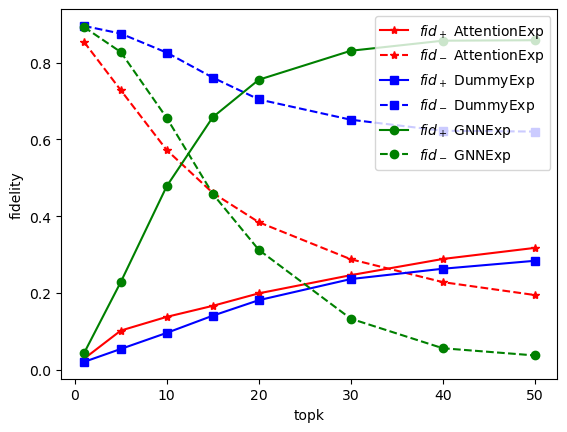

In [11]:
GATAttExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GAT_Att.csv"))
GATDummyExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GAT_Dummy.csv"))
GATGNNExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GAT_GNN.csv"))

plt.plot(GATAttExp['topk'], GATAttExp['fidp'], 'r*-', label=r'$fid_+$ AttentionExp')
plt.plot(GATAttExp['topk'], GATAttExp['fidm'], 'r*--', label=r'$fid_-$ AttentionExp')
plt.plot(GATDummyExp['topk'], GATDummyExp['fidp'], 'bs-', label=r'$fid_+$ DummyExp')
plt.plot(GATDummyExp['topk'], GATDummyExp['fidm'], 'bs--', label=r'$fid_-$ DummyExp')
plt.plot(GATGNNExp['topk'], GATGNNExp['fidp'], 'go-', label=r'$fid_+$ GNNExp')
plt.plot(GATGNNExp['topk'], GATGNNExp['fidm'], 'go--', label=r'$fid_-$ GNNExp')
plt.xlabel('topk')
plt.ylabel('fidelity')
plt.legend()

The above plot is a textbook example of what we mentioned in the introduction: $fid_-$ decreases when we allow more features and $fid_+$ increases. All explainers perform better than the dummy explainer and GNNExplainer performs by far the best. According to the definition in the introduction it provides a sufficient and necessary explanation when a decent number of features and edges are allowed.

## 1.2 Explaining Prediction with the GIN Architecture
<a id='GIN_sec'></a>
Let us now have a look at the GAT Architecture. We first load the model and then we redo the same steps as for the GAT architecture with the only difference that the AttentionExplainer is not available for the GIN architecture.

In [4]:
from models import simpleGIN

do = 0.2
num_layer = 3
num_hidden = 64

modelGIN = simpleGIN(in_channels=ds[0].x.size(1), dim_h=num_hidden, out_channels=ds[0].y.size(0), num_layers=num_layer, dropout=do)
state_dict = torch.load(os.path.join(root_dir, "models/final/GIN_best.pth"))['net']
modelGIN.load_state_dict(state_dict)
modelGIN.to(device)

simpleGIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=67, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
  ))
  (GIN_layers): ModuleList(
    (0-1): 2 x GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): ReLU()
    ))
  )
  (classifier): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)

**Dummy Explainer**

We start with the dummy explainer which generates random masks, i.e. it does not provide any explanation and serves as a baseline comparison

In [13]:
fidpDummy, fidmDummy = benchmark_explainer(modelGIN, DummyExplainer(), ds, topk_list,
                                           node_mask='attributes', edge_mask='object')

GINDummyExp = pd.DataFrame({'topk': topk_list, "fidp": fidpDummy, 'fidm': fidmDummy})
GINDummyExp.to_csv(os.path.join(os.getcwd(), "explain_results/GIN_Dummy.csv"), index=False)

Topk=1, Start Explainer


100%|██████████| 6542/6542 [00:09<00:00, 677.17it/s]


Result: fidelity_plus=0.0214, fidelity_minus=0.1056
Topk=5, Start Explainer


100%|██████████| 6542/6542 [00:09<00:00, 680.42it/s]


Result: fidelity_plus=0.0541, fidelity_minus=0.1056
Topk=10, Start Explainer


100%|██████████| 6542/6542 [00:09<00:00, 682.11it/s]


Result: fidelity_plus=0.0760, fidelity_minus=0.1056
Topk=15, Start Explainer


100%|██████████| 6542/6542 [00:09<00:00, 676.64it/s]


Result: fidelity_plus=0.0912, fidelity_minus=0.1056
Topk=20, Start Explainer


100%|██████████| 6542/6542 [00:09<00:00, 681.18it/s]


Result: fidelity_plus=0.0985, fidelity_minus=0.1056
Topk=30, Start Explainer


100%|██████████| 6542/6542 [00:09<00:00, 680.25it/s]


Result: fidelity_plus=0.1028, fidelity_minus=0.1056
Topk=40, Start Explainer


100%|██████████| 6542/6542 [00:09<00:00, 681.01it/s]


Result: fidelity_plus=0.1045, fidelity_minus=0.1056
Topk=50, Start Explainer


100%|██████████| 6542/6542 [00:09<00:00, 679.98it/s]

Result: fidelity_plus=0.1052, fidelity_minus=0.1056


**GNNExplainer**

Last but not least we use GNNExplainer to learn an ideal mask for our GIN network

In [14]:
fidpGNNExp, fidmGNNExp = benchmark_explainer(modelGIN, GNNExplainer(epochs=50), ds, topk_list,
                                           node_mask='attributes', edge_mask='object')

GINGNNExp = pd.DataFrame({'topk': topk_list, "fidp": fidpGNNExp, 'fidm': fidmGNNExp})
GINGNNExp.to_csv(os.path.join(os.getcwd(), "explain_results/GIN_GNN.csv"), index=False)

Topk=1, Start Explainer


100%|██████████| 6542/6542 [05:14<00:00, 20.80it/s]


Result: fidelity_plus=0.0233, fidelity_minus=0.1056
Topk=5, Start Explainer


100%|██████████| 6542/6542 [05:12<00:00, 20.91it/s]


Result: fidelity_plus=0.0682, fidelity_minus=0.1056
Topk=10, Start Explainer


100%|██████████| 6542/6542 [05:13<00:00, 20.87it/s]


Result: fidelity_plus=0.0945, fidelity_minus=0.1056
Topk=15, Start Explainer


100%|██████████| 6542/6542 [05:13<00:00, 20.88it/s]


Result: fidelity_plus=0.1037, fidelity_minus=0.1056
Topk=20, Start Explainer


100%|██████████| 6542/6542 [05:13<00:00, 20.90it/s]


Result: fidelity_plus=0.1062, fidelity_minus=0.1056
Topk=30, Start Explainer


100%|██████████| 6542/6542 [05:13<00:00, 20.90it/s]


Result: fidelity_plus=0.1059, fidelity_minus=0.1056
Topk=40, Start Explainer


100%|██████████| 6542/6542 [05:14<00:00, 20.82it/s]


Result: fidelity_plus=0.1057, fidelity_minus=0.1056
Topk=50, Start Explainer


100%|██████████| 6542/6542 [05:16<00:00, 20.67it/s]

Result: fidelity_plus=0.1056, fidelity_minus=0.1056


**Summary GIN Explainability**

Let us now compare the results of the different explainers applied to the GAT architecture. The following plot shows the fidelity curves with $fid_+$ in solid and $fid_-$ in dashed.

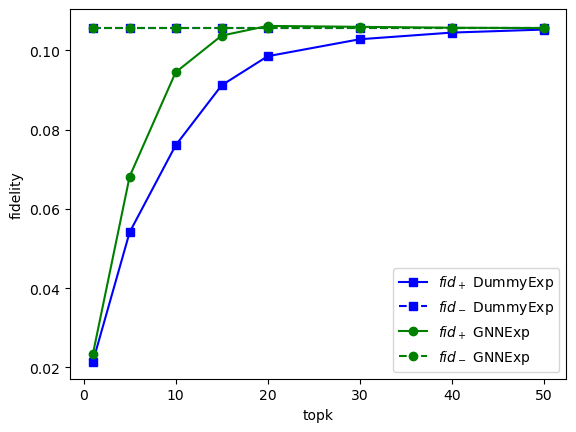

In [15]:
GINDummyExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GIN_Dummy.csv"))
GINGNNExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GIN_GNN.csv"))

plt.plot(GINDummyExp['topk'], GINDummyExp['fidp'], 'bs-', label=r'$fid_+$ DummyExp')
plt.plot(GINDummyExp['topk'], GINDummyExp['fidm'], 'bs--', label=r'$fid_-$ DummyExp')
plt.plot(GINGNNExp['topk'], GINGNNExp['fidp'], 'go-', label=r'$fid_+$ GNNExp')
plt.plot(GINGNNExp['topk'], GINGNNExp['fidm'], 'go--', label=r'$fid_-$ GNNExp')
plt.xlabel('topk')
plt.ylabel('fidelity')
plt.legend()

This does not look like the expected behavior of a good explainer. The $fid_-$ value does not decrease but it starts at a low value and $fid_+$ does not increase above the $fid_-$ value. In order to figure out, let us see what the fidelity curve looks like for the two classes separately.

In [7]:
indices0, indices1 = [], []
for i in range(len(ds)):
    if torch.equal(ds[i].y,torch.tensor([0,1])):
        indices1.append(i)
    else:
        indices0.append(i)
ds0 = ds[indices0]
ds1 = ds[indices1]

Now we apply GNNExplainer to both datasets

In [18]:
fidpGNNExp1, fidmGNNExp1 = benchmark_explainer(modelGIN, GNNExplainer(epochs=50), ds1, [1, 5, 10, 15, 20, 30, 40, 50, 100, 500, 1000],
                                           node_mask='attributes', edge_mask='object')

GINGNNExp1 = pd.DataFrame({'topk': [1, 5, 10, 15, 20, 30, 40, 50, 100, 500, 1000], "fidp": fidpGNNExp1, 'fidm': fidmGNNExp1})
GINGNNExp1.to_csv(os.path.join(os.getcwd(), "explain_results/GIN_GNN_1.csv"), index=False)

Topk=1, Start Explainer


100%|██████████| 768/768 [00:38<00:00, 20.16it/s]


Result: fidelity_plus=0.1061, fidelity_minus=0.6660
Topk=5, Start Explainer


100%|██████████| 768/768 [00:38<00:00, 19.73it/s]


Result: fidelity_plus=0.4036, fidelity_minus=0.6660
Topk=10, Start Explainer


100%|██████████| 768/768 [00:39<00:00, 19.44it/s]


Result: fidelity_plus=0.5820, fidelity_minus=0.6660
Topk=15, Start Explainer


100%|██████████| 768/768 [00:39<00:00, 19.43it/s]


Result: fidelity_plus=0.6380, fidelity_minus=0.6660
Topk=20, Start Explainer


100%|██████████| 768/768 [00:38<00:00, 20.06it/s]


Result: fidelity_plus=0.6556, fidelity_minus=0.6660
Topk=30, Start Explainer


100%|██████████| 768/768 [00:39<00:00, 19.48it/s]


Result: fidelity_plus=0.6660, fidelity_minus=0.6660
Topk=40, Start Explainer


100%|██████████| 768/768 [00:37<00:00, 20.61it/s]


Result: fidelity_plus=0.6660, fidelity_minus=0.6660
Topk=50, Start Explainer


100%|██████████| 768/768 [00:36<00:00, 20.97it/s]


Result: fidelity_plus=0.6660, fidelity_minus=0.6660
Topk=100, Start Explainer


100%|██████████| 768/768 [00:36<00:00, 20.94it/s]


Result: fidelity_plus=0.6660, fidelity_minus=0.6660
Topk=500, Start Explainer


100%|██████████| 768/768 [00:36<00:00, 20.96it/s]


Result: fidelity_plus=0.6660, fidelity_minus=0.6660
Topk=1000, Start Explainer


100%|██████████| 768/768 [00:36<00:00, 21.11it/s]

Result: fidelity_plus=0.6660, fidelity_minus=0.6660


In [13]:
fidpGNNExp0, fidmGNNExp0 = benchmark_explainer(modelGIN, GNNExplainer(epochs=50), ds0, topk_list,
                                           node_mask='attributes', edge_mask='object')

GINGNNExp0 = pd.DataFrame({'topk': topk_list, "fidp": fidpGNNExp0, 'fidm': fidmGNNExp0})
GINGNNExp0.to_csv(os.path.join(os.getcwd(), "explain_results/GIN_GNN_0.csv"), index=False)

Topk=1, Start Explainer


100%|██████████| 5774/5774 [04:43<00:00, 20.35it/s]


Result: fidelity_plus=0.0130, fidelity_minus=0.0311
Topk=5, Start Explainer


100%|██████████| 5774/5774 [04:42<00:00, 20.45it/s]


Result: fidelity_plus=0.0268, fidelity_minus=0.0311
Topk=10, Start Explainer


100%|██████████| 5774/5774 [04:48<00:00, 20.03it/s]


Result: fidelity_plus=0.0330, fidelity_minus=0.0311
Topk=15, Start Explainer


100%|██████████| 5774/5774 [11:10<00:00,  8.61it/s]  


Result: fidelity_plus=0.0323, fidelity_minus=0.0311
Topk=20, Start Explainer


100%|██████████| 5774/5774 [26:29<00:00,  3.63it/s]    


Result: fidelity_plus=0.0317, fidelity_minus=0.0311
Topk=30, Start Explainer


100%|██████████| 5774/5774 [04:47<00:00, 20.11it/s]


Result: fidelity_plus=0.0320, fidelity_minus=0.0311
Topk=40, Start Explainer


100%|██████████| 5774/5774 [04:49<00:00, 19.97it/s]


Result: fidelity_plus=0.0311, fidelity_minus=0.0311
Topk=50, Start Explainer


100%|██████████| 5774/5774 [04:51<00:00, 19.81it/s]

Result: fidelity_plus=0.0313, fidelity_minus=0.0311


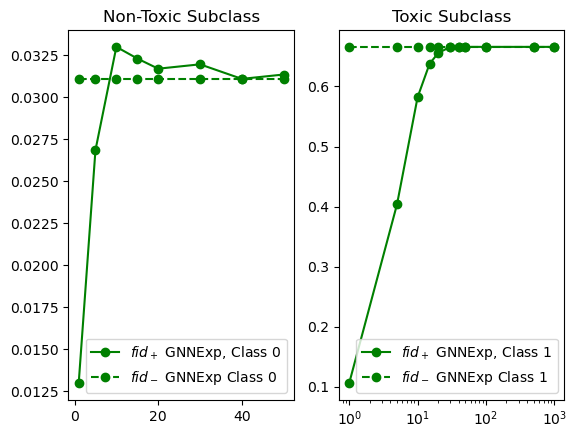

In [22]:
GINGNNExp0 = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GIN_GNN_0.csv"))
GINGNNExp1 = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GIN_GNN_1.csv"))

plt.subplot(1, 2, 1)
plt.plot(GINGNNExp0['topk'], GINGNNExp0['fidp'], 'go-', label=r'$fid_+$ GNNExp, Class 0')
plt.plot(GINGNNExp0['topk'], GINGNNExp0['fidm'], 'go--', label=r'$fid_-$ GNNExp Class 0')
plt.title('Non-Toxic Subclass')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogx(GINGNNExp1['topk'], GINGNNExp1['fidp'], 'go-', label=r'$fid_+$ GNNExp, Class 1')
plt.semilogx(GINGNNExp1['topk'], GINGNNExp1['fidm'], 'go--', label=r'$fid_-$ GNNExp Class 1')
plt.title('Toxic Subclass')
plt.legend()

This seems to suggest that the model either learned to classify everything into non-toxic since this class is more prevelant or is overfitted. For the non-toxic subclass $fid_-$ is at a very low level, regardless of the number of features considered. Interestingly $fid_+$ stays low which means that removing important features does not change anything in the model prediction. For the toxic subclass $fid_-$ does not improve even for a very large number of features. The model seems very bad at identifying toxic molecules. Another possibility is that the explainer is not able to find important features.

## 1.3 Explaining Prediction with the MPNN Architecture
<a id='MPNN_sec'></a>
Let us now have a look at the MPNN Architecture. We first load the model and then we redo the same steps as for the GAT architecture with the only difference that the AttentionExplainer is not available for the GIN architecture.

In [5]:
from models import MPNNModel

do = 0.2
num_layer = 2
num_hidden = 64


modelMPNN = MPNNModel(node_dim=ds[0].x.size(1), edge_dim=ds[0].edge_attr.size(1), hidden_dim=num_hidden, num_layers=num_layer, dropout=do)
state_dict = torch.load(os.path.join(root_dir, "models/final/MPNN_best.pth"))['net']
modelMPNN.load_state_dict(state_dict)
modelMPNN.to(device)

MPNNModel(
  (node_embedding): Linear(in_features=67, out_features=64, bias=True)
  (mpnn_layers): ModuleList(
    (0-1): 2 x MPNNLayer()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)

**Dummy Explainer**

We start with the dummy explainer which generates random masks, i.e. it does not provide any explanation and serves as a baseline comparison

In [6]:
fidpDummy, fidmDummy = benchmark_explainer(modelMPNN, DummyExplainer(), ds, topk_list,
                                           node_mask='attributes', edge_mask='object')

MPNNDummyExp = pd.DataFrame({'topk': topk_list, "fidp": fidpDummy, 'fidm': fidmDummy})
MPNNDummyExp.to_csv(os.path.join(os.getcwd(), "explain_results/MPNN_Dummy.csv"), index=False)

Topk=1, Start Explainer


100%|██████████| 6542/6542 [00:08<00:00, 778.29it/s]


Result: fidelity_plus=0.0160, fidelity_minus=0.3797
Topk=5, Start Explainer


100%|██████████| 6542/6542 [00:07<00:00, 829.24it/s]


Result: fidelity_plus=0.0338, fidelity_minus=0.7059
Topk=10, Start Explainer


100%|██████████| 6542/6542 [00:07<00:00, 831.86it/s]


Result: fidelity_plus=0.0502, fidelity_minus=0.7291
Topk=15, Start Explainer


100%|██████████| 6542/6542 [00:07<00:00, 821.38it/s]


Result: fidelity_plus=0.0581, fidelity_minus=0.7219
Topk=20, Start Explainer


100%|██████████| 6542/6542 [00:07<00:00, 826.39it/s]


Result: fidelity_plus=0.0603, fidelity_minus=0.7103
Topk=30, Start Explainer


100%|██████████| 6542/6542 [00:07<00:00, 831.91it/s]


Result: fidelity_plus=0.0601, fidelity_minus=0.6826
Topk=40, Start Explainer


100%|██████████| 6542/6542 [00:07<00:00, 829.52it/s]


Result: fidelity_plus=0.0670, fidelity_minus=0.6618
Topk=50, Start Explainer


100%|██████████| 6542/6542 [00:07<00:00, 832.65it/s]

Result: fidelity_plus=0.0663, fidelity_minus=0.6461


**GNNExplainer**

Last but not least we use GNNExplainer to learn an ideal mask for our MPNN model. Note that the edge mask results in an error for this architecture, which is why we have to set it to zero

In [4]:
fidpGNNExp, fidmGNNExp = benchmark_explainer(modelMPNN, GNNExplainer(epochs=50), ds, topk_list,
                                           node_mask='attributes', edge_mask=None)

MPNNGNNExp = pd.DataFrame({'topk': topk_list, "fidp": fidpGNNExp, 'fidm': fidmGNNExp})
MPNNGNNExp.to_csv(os.path.join(os.getcwd(), "explain_results/MPNN_GNN.csv"), index=False)

Topk=1, Start Explainer


100%|██████████| 6542/6542 [03:40<00:00, 29.66it/s]


Result: fidelity_plus=0.0241, fidelity_minus=0.5969
Topk=5, Start Explainer


100%|██████████| 6542/6542 [03:41<00:00, 29.56it/s]


Result: fidelity_plus=0.1046, fidelity_minus=0.4911
Topk=10, Start Explainer


100%|██████████| 6542/6542 [03:40<00:00, 29.63it/s]


Result: fidelity_plus=0.1709, fidelity_minus=0.3882
Topk=15, Start Explainer


100%|██████████| 6542/6542 [03:35<00:00, 30.30it/s]


Result: fidelity_plus=0.2201, fidelity_minus=0.2710
Topk=20, Start Explainer


100%|██████████| 6542/6542 [03:35<00:00, 30.29it/s]


Result: fidelity_plus=0.2559, fidelity_minus=0.1801
Topk=30, Start Explainer


100%|██████████| 6542/6542 [03:36<00:00, 30.19it/s]


Result: fidelity_plus=0.2975, fidelity_minus=0.0841
Topk=40, Start Explainer


100%|██████████| 6542/6542 [03:38<00:00, 29.98it/s]


Result: fidelity_plus=0.3150, fidelity_minus=0.0368
Topk=50, Start Explainer


100%|██████████| 6542/6542 [03:40<00:00, 29.73it/s]

Result: fidelity_plus=0.3128, fidelity_minus=0.0188


**Summary MPNN Explainability**

Let us now compare the results of the different explainers applied to the MPNN architecture. The following plot shows the fidelity curves with $fid_+$ in solid and $fid_-$ in dashed.

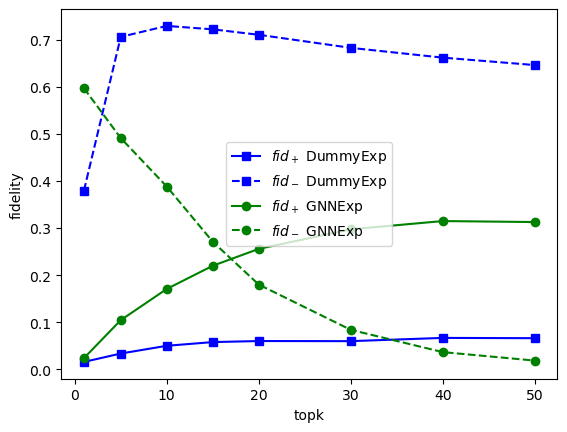

In [5]:
MPNNDummyExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/MPNN_Dummy.csv"))
MPNNGNNExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/MPNN_GNN.csv"))

plt.plot(MPNNDummyExp['topk'], MPNNDummyExp['fidp'], 'bs-', label=r'$fid_+$ DummyExp')
plt.plot(MPNNDummyExp['topk'], MPNNDummyExp['fidm'], 'bs--', label=r'$fid_-$ DummyExp')
plt.plot(MPNNGNNExp['topk'], MPNNGNNExp['fidp'], 'go-', label=r'$fid_+$ GNNExp')
plt.plot(MPNNGNNExp['topk'], MPNNGNNExp['fidm'], 'go--', label=r'$fid_-$ GNNExp')
plt.xlabel('topk')
plt.ylabel('fidelity')
plt.legend()

As expected, the dummy explainer does not provide a good explanation for the model predictions. However, the GNNExplainer finds a good set of features to explain the model predictions. The explanation is only sufficient though, since $fid_+$ does not increase very much when more features are included. This means that removing the important features does not change the model predictions. Since this is a binary classification problem, this is not necessarily problematic (there are only two possible classes).

## 1.4 Comparing Different Network Architectures
<a id='comp_sec'></a>

Now we compare the fidelity curves for the different network architectures to find which network architecture is best suited for explainability algorithms.

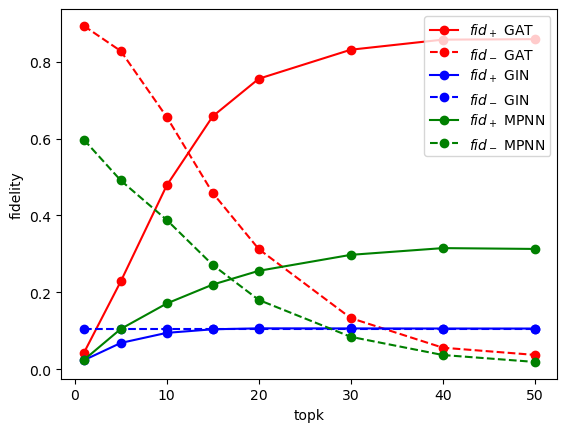

In [23]:
MPNNGNNExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/MPNN_GNN.csv"))
GINGNNExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GIN_GNN.csv"))
GATGNNExp = pd.read_csv(os.path.join(os.getcwd(), "explain_results/GAT_GNN.csv"))

plt.plot(GATGNNExp['topk'], GATGNNExp['fidp'], 'ro-', label=r'$fid_+$ GAT')
plt.plot(GATGNNExp['topk'], GATGNNExp['fidm'], 'ro--', label=r'$fid_-$ GAT')
plt.plot(GINGNNExp['topk'], GINGNNExp['fidp'], 'bo-', label=r'$fid_+$ GIN')
plt.plot(GINGNNExp['topk'], GINGNNExp['fidm'], 'bo--', label=r'$fid_-$ GIN')
plt.plot(MPNNGNNExp['topk'], MPNNGNNExp['fidp'], 'go-', label=r'$fid_+$ MPNN')
plt.plot(MPNNGNNExp['topk'], MPNNGNNExp['fidm'], 'go--', label=r'$fid_-$ MPNN')
plt.xlabel('topk')
plt.ylabel('fidelity')
plt.legend()


In our study the attention network seems to be best suited to find reliable, i.e. sufficient and necessary, explanation for the model predictions. For the MPNN architecture we can find sufficient explanations but they are not as necessary as for the GAT network. For the GIN architecture we were unfortunately not able to find good explanations.

## 2. Examples of GNNExplainer Explanations
<a id='example'></a>

Let us now see what the actual explanations look like. We compare the GNNExplainer predictions for `topk=10` for two example graphs and all considered architectures. We choose one example graph which is non-toxic and that all models classify as non-toxic and one graph that is toxic and all graphs classify as non-toxic. Ideally GNNExplainer applied to all architectures is going to find the same key features that lead to the prediction. That would be a very robust result that could be shown to a chemist or biologist who might be able to identify specific molecular properties that are responsible for the prediction. This could give new insights to what causes toxicity.

The below visualization code is taken from https://github.com/KRLGroup/GraphCW/tree/master

In [47]:
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io
CLR_MIN = (0.5, 0.5, 1)
CLR_MAX = (1, 0.5, 0.5)

def visualize_attrs(mol, attr, size=300, normScale=None):
    # Normalization
    if normScale: M = normScale
    else: M = np.max(np.abs(attr))
    attr /= M

    atom_clrs = {}
    bond_clrs = {}
    hit_ats = []
    hit_bonds = []
    for i, at in enumerate(attr):
        hit_ats.append(i)
        atom_clrs[i] = attr2clr(at)

    for i, bond in enumerate(mol.GetBonds()):
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        at = (attr[a2] + attr[a1]) / 2
        hit_bonds.append(i)
        bond_clrs[i] = attr2clr(at)

    d = rdMolDraw2D.MolDraw2DCairo(size, size)
    rdMolDraw2D.PrepareAndDrawMolecule(
        d, mol,
        highlightAtoms=hit_ats,
        highlightAtomColors=atom_clrs,
        highlightBonds=hit_bonds,
        highlightBondColors=bond_clrs
    )

    d.FinishDrawing()
    img_bytes = d.GetDrawingText()
    img = Image.open(io.BytesIO(img_bytes))
    return img

def attr2clr(a):
    CM = np.array(CLR_MAX)   # Max
    Cm = np.array(CLR_MIN)   # Min
    Cw = np.array((1, 1, 1)) # white
    GradPos = CM - Cw
    GradNeg = Cm - Cw
    
    if a > 0: clr = Cw + GradPos * a
    else: clr = Cw + GradNeg * -a

    return tuple(clr)

def visualize_explanation(exp, data):
    edge_mask = exp.edge_mask
    
    attrs = torch.ones(data.x.shape[0])

    for i in range(data.x.shape[0]):
        l = []
        for e in range(data.edge_index.shape[1]):
            if data.edge_index[0,e] == i or data.edge_index[1,e] == i:
                l.append(edge_mask[e])
        attrs[i] = sum(l) / (len(l)+1e-6)
        
    attrs = (attrs - attrs.min()) / (attrs.max() - attrs.min())

    img = visualize_attrs(data.mol, -attrs.numpy())
    plt.imshow(img)
    plt.axis('off')

Select element 1 and 16 from the dataset. They belong to class 0 and 1 respectively and are correctly classified by all networks

In [18]:
i0 = 1
i1 = 16

print(ds[i0].y)
print(ds[i1].y)
modelGAT.eval()
modelGIN.eval()
modelMPNN.eval()
with torch.no_grad():
    print('Prediction for class 0 element:')
    print(modelGAT(ds[i0].x,ds[i0].edge_index))
    print(modelGIN(ds[i0].x,ds[i0].edge_index))
    print(modelMPNN(ds[i0].x,ds[i0].edge_index,ds[i0].edge_attr))
    print('Prediction for class 1 element:')
    print(modelGAT(ds[i1].x,ds[i1].edge_index))
    print(modelGIN(ds[i1].x,ds[i1].edge_index))
    print(modelMPNN(ds[i1].x,ds[i1].edge_index,ds[i1].edge_attr))


tensor([1., 0.])
tensor([0., 1.])
Prediction for class 0 element:
tensor([[ 2.0900, -1.6442]])
tensor([[ 0.4483, -0.8307]])
tensor([[ 2.1790, -2.2574]])
Prediction for class 1 element:
tensor([[-1.3444,  0.5481]])
tensor([[-3.4538,  2.4930]])
tensor([[-1.4698,  1.4657]])


Now let us get the explanations for these two graphs using `topk=10`

**GAT Network**

In [ ]:
GATexplainer = Explainer(
        model=modelGAT,
        algorithm=GNNExplainer(epochs=50),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
        threshold_config=dict(threshold_type='topk', value=10)
)

GATexplanation0 = GATexplainer(ds[i0].x, ds[i0].edge_index)
GATexplanation1 = GATexplainer(ds[i1].x, ds[i1].edge_index)

GATexplainerAtt = Explainer(
        model=modelGAT,
        algorithm=AttentionExplainer(),
        explanation_type='model',
        node_mask_type=None,
        edge_mask_type='object',
        model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
        threshold_config=dict(threshold_type='topk', value=10)
)

GATexplanation0Att = GATexplainerAtt(ds[i0].x, ds[i0].edge_index)
GATexplanation1Att = GATexplainerAtt(ds[i1].x, ds[i1].edge_index)

Text(0.5, 1.0, 'Class 1 GAT Att')

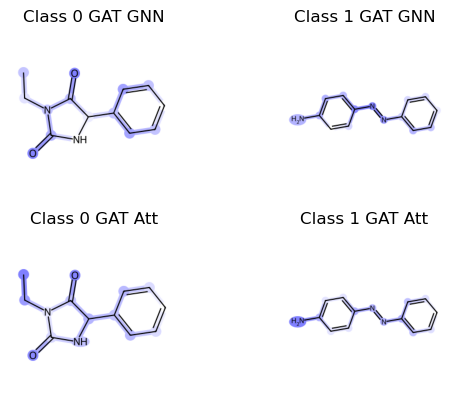

In [53]:
plt.subplot(2,2,1)
visualize_explanation(GATexplanation0, ds[i0])
plt.title('Class 0 GAT GNN')
plt.subplot(2,2,2)
visualize_explanation(GATexplanation1, ds[i1])
plt.title('Class 1 GAT GNN')
plt.subplot(2,2,3)
visualize_explanation(GATexplanation0Att, ds[i0])
plt.title('Class 0 GAT Att')
plt.subplot(2,2,4)
visualize_explanation(GATexplanation1Att, ds[i1])
plt.title('Class 1 GAT Att')

GNNExplainer and the AttentionExplainer seem to find some similar edges that they deem important within the GAT architecture

**GIN Network**

In [54]:
GINexplainer = Explainer(
        model=modelGIN,
        algorithm=GNNExplainer(epochs=50),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(mode='binary_classification', task_level='graph', return_type='raw'),
        threshold_config=dict(threshold_type='topk', value=10)
)

GINexplanation0 = GINexplainer(ds[i0].x, ds[i0].edge_index)
GINexplanation1 = GINexplainer(ds[i1].x, ds[i1].edge_index)

Text(0.5, 1.0, 'Class 1 GAT GNN')

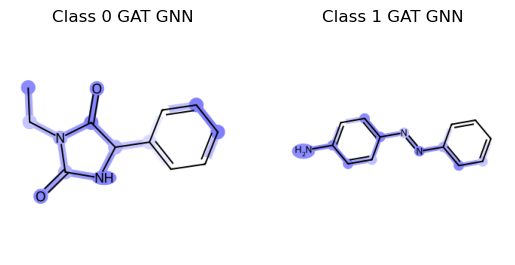

In [55]:
plt.subplot(1,2,1)
visualize_explanation(GINexplanation0, ds[i0])
plt.title('Class 0 GAT GNN')
plt.subplot(1,2,2)
visualize_explanation(GINexplanation1, ds[i1])
plt.title('Class 1 GAT GNN')

The class 1 edges seem similar but for class 0 there are some notable differences, such as the edge on the very right or the whole ring on the left, which seems important. However, the fidelity scores for this model were inconclusive. so it is not clear if those differences are meaningful.

**MPNN Model**

For the MPNN model we unfortunately cannot visualize the most important edges since GNNExplainer did not support the edge mask for this model.